# Installs, data, imports

In [1]:
!pip install -qq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [2]:
from functools import partial
import os.path
import os
import shutil
import json

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from datasets import load_dataset

from fastai.data.core import DataLoaders
from fastai.optimizer import OptimWrapper
from fastai.learner import Learner
import fastai.callback.schedule
from fastai.callback.all import SaveModelCallback
from fastai.metrics import accuracy

In [3]:
dataset = load_dataset("danavery/urbansound8K")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'],
        num_rows: 8732
    })
})

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
plt.style.use('ggplot')

# Data preparation

In [7]:
dataset['train'][3]['audio']

{'path': '100263-2-0-126.wav',
 'array': array([ 2.59399414e-04,  1.52587891e-05, -2.13623047e-04, ...,
         3.05175781e-04,  4.73022461e-04, -9.46044922e-04]),
 'sampling_rate': 44100}

In [8]:
BATCH_SIZE = 16
MAX_LENGTH = 384000

In [9]:
def collate_fn(batch):
    tensors, targets = [], []

    for element in batch:
        waveform = element['audio']['array']
        pad_size = [0, MAX_LENGTH - waveform.shape[0]]
        wf_padded = F.pad(waveform, pad=pad_size, mode='constant', value=0.0)
        tensors += [torch.unsqueeze(wf_padded, 0)]

        targets += [element['classID']]

    return torch.stack(tensors), torch.stack(targets)

def make_dataloaders(dataset, batch_size, test_fold=10):
    dataset_trimmed = dataset['train'].filter(lambda sample: sample['audio']['array'].size <= MAX_LENGTH)

    train_dataset = dataset_trimmed.filter(lambda sample: sample['fold'] != test_fold)
    one_batch_dataset = train_dataset.select(range(batch_size))
    test_dataset = dataset_trimmed.filter(lambda sample: sample['fold'] == test_fold)

    print("Train size", len(train_dataset))
    print("One-batch size", len(one_batch_dataset))
    print("Test size", len(test_dataset))

    if DEVICE == "cuda":
        num_workers = 4
        pin_memory = True
    else:
        num_workers = 0
        pin_memory = False

    train_loader = DataLoader(
        train_dataset.with_format("torch", device=DEVICE),
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory)

    onebatch_loader = DataLoader(
        one_batch_dataset.with_format("torch", device=DEVICE),
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory)

    test_loader = DataLoader(
        test_dataset.with_format("torch", device=DEVICE),
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory)

    return train_loader, onebatch_loader, test_loader

train_loader, onebatch_loader, test_loader = make_dataloaders(dataset, BATCH_SIZE)
onebatch_dls = DataLoaders(onebatch_loader, onebatch_loader, device=DEVICE)
fulltrain_dls = DataLoaders(train_loader, test_loader, device=DEVICE)

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8715 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8715 [00:00<?, ? examples/s]

Train size 7878
One-batch size 16
Test size 837


In [10]:
for waveform, target in train_loader:
    print(waveform.shape)
    print(target.shape)
    break

torch.Size([16, 1, 384000])
torch.Size([16])


# Model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



### Baseline (conv)

In [ ]:
# TODO: cleanup this code

import sys
sys.path.append('./drive/MyDrive/Projects/MiniSoundFinder/lib/')

import classifiers

import importlib
importlib.reload(classifiers)

<module 'classifiers' from '/content/./drive/MyDrive/Projects/MiniSoundFinder/lib/classifiers.py'>

In [ ]:
# class ClassifierBaseline(nn.Module):
#     def __init__(self, input_channels, output_size):
#         super().__init__()

#         start_channels = 4
#         main_channels = 16
#         features_len = 16

#         self.features = nn.Sequential(
#             nn.Conv1d(input_channels, start_channels, kernel_size=80, stride=64, bias=False),
#             nn.BatchNorm1d(start_channels),
#             nn.ReLU(),
#             nn.Conv1d(start_channels, main_channels, kernel_size=3, stride=4, bias=False),
#             nn.BatchNorm1d(main_channels),
#             nn.ReLU(),
#             nn.Conv1d(main_channels, main_channels, kernel_size=3, stride=4, bias=False),
#             nn.BatchNorm1d(main_channels),
#             nn.ReLU(),
#             nn.AdaptiveMaxPool1d(features_len))

#         self.classifier = nn.Linear(main_channels * features_len, output_size)


#     def forward(self, x):
#         features = self.features(x)
#         logits = self.classifier(features.reshape(features.shape[0], -1))
#         return F.log_softmax(logits, dim=-1)

### Audio ResNet-style

In [ ]:
# class ResidualConv1dBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Conv1d(in_channels, out_channels, kernel_size=3,
#                       stride=stride, bias=False, padding=1),
#             nn.BatchNorm1d(out_channels),
#             nn.ReLU(),
#             nn.Conv1d(out_channels, out_channels,
#                       kernel_size=3, bias=False, padding=1),
#             nn.BatchNorm1d(out_channels),
#         )

#         if in_channels != out_channels or stride != 1:
#             self.shortcut = nn.Sequential(
#                 nn.Conv1d(in_channels, out_channels, kernel_size=1,
#                           stride=stride, bias=False),
#                 nn.BatchNorm1d(out_channels),
#             )
#         else:
#             self.shortcut = nn.Identity()


#     def forward(self, x):
#         return F.relu(self.layers(x) + self.shortcut(x))


# class BottleneckConv1dBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, bottleneck_channels, stride=1):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False),
#             nn.BatchNorm1d(bottleneck_channels),
#             nn.ReLU(),
#             nn.Conv1d(bottleneck_channels, bottleneck_channels, kernel_size=3,
#                       stride=stride, bias=False, padding=1),
#             nn.BatchNorm1d(bottleneck_channels),
#             nn.ReLU(),
#             nn.Conv1d(bottleneck_channels, out_channels, kernel_size=1, bias=False),
#             nn.BatchNorm1d(out_channels),
#         )

#         if in_channels != out_channels or stride != 1:
#             self.shortcut = nn.Sequential(
#                 nn.Conv1d(in_channels, out_channels, kernel_size=1,
#                           stride=stride, bias=False),
#                 nn.BatchNorm1d(out_channels),
#             )
#         else:
#             self.shortcut = nn.Identity()

#     def forward(self, x):
#         return F.relu(self.layers(x) + self.shortcut(x))

In [ ]:
# class AudioResNet(nn.Module):
#     def __init__(self, input_channels, output_size, layers_args):
#         super().__init__()

#         hidden, kernel, stride = layers_args[0]
#         layers = [
#             nn.Conv1d(input_channels, hidden, kernel_size=kernel, stride=stride, bias=False),
#             nn.BatchNorm1d(hidden),
#             nn.ReLU(),
#         ]
#         for args in layers_args[1:-1]:
#             layers.append(ResidualConv1dBlock(*args))

#         hidden, pool = layers_args[-1]
#         layers.append(nn.AdaptiveMaxPool1d(pool))

#         self.features = nn.Sequential(*layers)

#         self.classifier = nn.Linear(hidden * pool, output_size)

#     def forward(self, x):
#         features = self.features(x)
#         logits = self.classifier(features.reshape(features.shape[0], -1))
#         return F.log_softmax(logits, dim=-1)

### Draft

In [ ]:
class DownsampleBlock(nn.Module):
    pass

class DilationBlock(nn.Module):
    pass

# Test/debug

In [ ]:
model = classifiers.BasicConvNet(input_channels=1, output_size=10).to(DEVICE)
print(model)
print("Number of parameters:", count_parameters(model))

opt_func = partial(OptimWrapper, opt=optim.Adam)
one_batch_learner = Learner(
    onebatch_dls, model,
    loss_func=F.nll_loss, opt_func=opt_func, metrics=accuracy)

BasicConvNet(
  (features): Sequential(
    (0): Conv1d(1, 4, kernel_size=(80,), stride=(64,), bias=False)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 16, kernel_size=(3,), stride=(4,), bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(16, 16, kernel_size=(3,), stride=(4,), bias=False)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveMaxPool1d(output_size=16)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)
Number of parameters: 3922


In [ ]:
one_batch_learner.fit_one_cycle(n_epoch=100, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,2.158001,2.309164,0.000000,00:01
1,2.084276,2.308569,0.000000,00:00
2,2.009598,2.306458,0.000000,00:00
3,1.930386,2.302796,0.000000,00:00
4,1.846974,2.297189,0.000000,00:00
5,1.766199,2.288746,0.000000,00:00
6,1.695578,2.276274,0.500000,00:00
7,1.632875,2.258349,0.500000,00:00
8,1.573206,2.232267,0.500000,00:00
9,1.514372,2.196039,0.500000,00:00


# Train & eval

### Baseline

In [ ]:
model = classifiers.BasicConvNet(input_channels=1, output_size=10).to(DEVICE)
print(model)
print("Number of parameters:", count_parameters(model))

opt_func = partial(OptimWrapper, opt=optim.Adam)
learner = Learner(
    fulltrain_dls, model,
    loss_func=F.nll_loss, opt_func=opt_func, metrics=accuracy)

BasicConvNet(
  (features): Sequential(
    (0): Conv1d(1, 4, kernel_size=(80,), stride=(64,), bias=False)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 16, kernel_size=(3,), stride=(4,), bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(16, 16, kernel_size=(3,), stride=(4,), bias=False)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveMaxPool1d(output_size=16)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)
Number of parameters: 3922


### ResNet

In [ ]:
# layers_args = [
#     [16, 17, 16],    # first conv hidden-kernel-stride
#     [16, 32, 2],  # residual blocks in-out-stride (ks=3)
#     [32, 32, 2],
#     [32, 32, 2],
#     [32, 64, 2],
#     [64, 64, 2],
#     [64, 64, 2],
#     [64, 128],    # final hidden-pool
# ]
# model = classifiers.AudioResNet(input_channels=1, output_size=10, layers_args=layers_args).to(DEVICE)
# print(model)
# print("Number of parameters:", count_parameters(model))

# opt_func = partial(OptimWrapper, opt=optim.Adam)
# learner = Learner(
#     fulltrain_dls, model,
#     loss_func=F.nll_loss, opt_func=opt_func, metrics=accuracy)

AudioResNet(
  (features): Sequential(
    (0): Conv1d(1, 16, kernel_size=(17,), stride=(16,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualConv1dBlock(
      (layers): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv1d(16, 32, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ResidualConv1dBlock(
      (layers): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=Fa

### Run

SuggestedLRs(valley=0.013182567432522774)

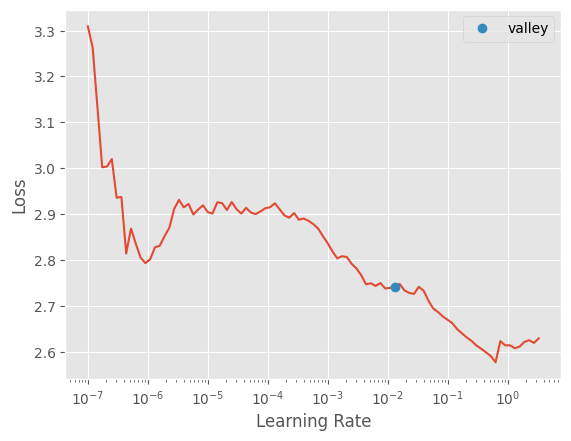

In [ ]:
learner.lr_find()

In [ ]:
config = {
    'fit': {
        'n_epoch': 10,
        'lr_max': 0.02,
    },
    'fit_func': 'fit_one_cycle',
    'dataset': 'danavery/urbansound8K',
    'dataset_details': 'folds: train 1-9, test 10',
}

learner.fit_one_cycle(
    **config['fit'],
    cbs=SaveModelCallback(monitor='accuracy'))

epoch,train_loss,valid_loss,accuracy,time
0,1.881613,1.840587,0.328554,01:04
1,1.669590,1.840133,0.281959,01:02
2,1.602674,1.668908,0.383513,01:02
3,1.575992,1.669870,0.384707,01:04
4,1.451059,1.587543,0.463560,01:04
5,1.335166,1.622518,0.396655,01:04
6,1.289543,1.560707,0.457587,01:05
7,1.200672,1.605182,0.476703,01:03
8,1.102371,1.628085,0.459976,01:03
9,1.085922,1.586771,0.458781,01:04


Better model found at epoch 0 with accuracy value: 0.3285543620586395.
Better model found at epoch 2 with accuracy value: 0.38351255655288696.
Better model found at epoch 3 with accuracy value: 0.3847073018550873.
Better model found at epoch 4 with accuracy value: 0.4635603427886963.
Better model found at epoch 7 with accuracy value: 0.4767025113105774.


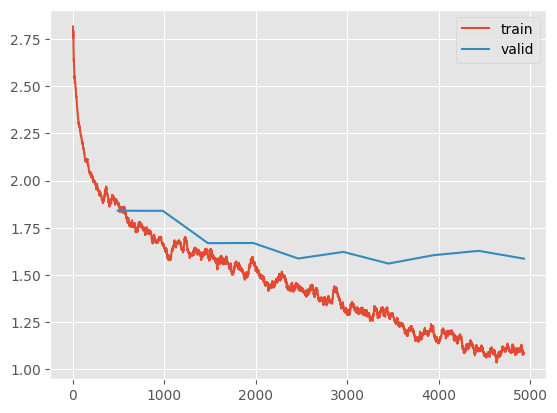

In [ ]:
plt.figure()
learner.recorder.plot_loss()
plt.savefig('loss.png')

In [ ]:
evaluator = Learner(
    fulltrain_dls, model,
    loss_func=F.nll_loss, metrics=accuracy)
train_res = evaluator.validate(0)
test_res = evaluator.validate(1)

eval_table = pd.DataFrame(
    data=[train_res, test_res],
    columns=["nll", "accuracy"],
    index=["train", "test"])
eval_table

,nll,accuracy
train,1.106343,0.609292
test,1.605182,0.476703


In [ ]:
def save_experiment(name, config, model, eval_table, experiment_folder, overwrite=False):
    folder = os.path.join(experiment_folder, name)
    os.makedirs(folder, exist_ok=overwrite)

    with open(os.path.join(folder, 'config.json'), "w") as cfg_file:
        json.dump(config, cfg_file)

    with open(os.path.join(folder, 'model_description.txt'), "w") as desc_file:
        print(model, file=desc_file)
        print("Number of parameters:", count_parameters(model), file=desc_file)

    shutil.copyfile('models/model.pth', os.path.join(folder, 'model.pth'))
    shutil.copyfile('loss.png', os.path.join(folder, 'loss.png'))

    eval_table.to_csv(os.path.join(folder, 'eval.csv'), index=False)


save_experiment(
    name="basic_convnet_01",
    config=config,
    model=model,
    eval_table=eval_table,
    experiment_folder='./drive/MyDrive/Projects/MiniSoundFinder/experiments/')

# Prediction examples

In [ ]:
weights = torch.load('models/model.pth', map_location=DEVICE)
model = classifiers.BasicConvNet(input_channels=1, output_size=10).to(DEVICE)
model.load_state_dict(weights, strict=True)

<All keys matched successfully>

In [ ]:
dataset['train'][4666]

{'audio': {'path': '188813-7-2-0.wav',
  'array': array([-0.00010872,  0.00053692,  0.00116116, ...,  0.00086272,
          0.00275093,  0.0031215 ]),
  'sampling_rate': 96000},
 'slice_file_name': '188813-7-2-0.wav',
 'fsID': 188813,
 'start': 6.203158,
 'end': 7.753947,
 'salience': 1,
 'fold': 10,
 'classID': 7,
 'class': 'jackhammer'}

In [ ]:
ind = [10, 21, 811, 1241, 4666]
parts = []
for i in ind:
    wf = torch.tensor(dataset['train'][i]['audio']['array'], dtype=torch.float32)
    pad_size = [0, MAX_LENGTH - wf.shape[0]]
    wf_padded = F.pad(wf, pad=pad_size, mode='constant', value=0.0)
    parts += [torch.unsqueeze(wf_padded, 0)]

inp = torch.stack(parts).to(DEVICE)

inp.shape

torch.Size([5, 1, 384000])

In [ ]:
pred = torch.exp(model(inp)).cpu().detach().numpy()

In [ ]:
classes = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
    'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

pd.DataFrame(data=pred, columns=classes, index=ind).T

,10,21,811,1241,4666
air_conditioner,0.022230,3.125824e-06,0.202588,0.146525,0.079464
car_horn,0.190917,9.875256e-06,0.005560,0.023504,0.031904
children_playing,0.107176,4.765128e-03,0.010732,0.505341,0.275136
dog_bark,0.332426,9.911169e-01,0.009675,0.092153,0.309591
drilling,0.126024,9.065765e-07,0.019225,0.009352,0.208331
engine_idling,0.015794,9.619391e-05,0.074607,0.071798,0.020111
gun_shot,0.058939,5.046691e-07,0.004826,0.002525,0.001146
jackhammer,0.018953,1.507004e-08,0.017163,0.013014,0.050452
siren,0.058607,5.181355e-04,0.007691,0.044700,0.000326
street_music,0.068934,3.489123e-03,0.647933,0.091089,0.023539


In [ ]:
for i in ind:
    print(i)
    print(dataset['train'][i]['audio']['path'])
    print(dataset['train'][i]['class'])
    print()

10
100648-1-1-0.wav
car_horn

21
100795-3-1-2.wav
dog_bark

811
115418-9-0-20.wav
street_music

1241
129750-2-0-46.wav
children_playing

4666
188813-7-2-0.wav
jackhammer



Listen to samples here:
https://www.kaggle.com/datasets/chrisfilo/urbansound8k

# Info

**Ref**

https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

https://wandb.ai/amanarora/Written-Reports/reports/Understanding-ResNets-A-Deep-Dive-into-Residual-Networks-with-PyTorch--Vmlldzo1MDAxMTk5#creating-the-model

https://paperswithcode.com/sota/environmental-sound-classification-on